# Taller AES

**Estudiante:** Omar David Toledo Leguizamón

Previo al taller, instalamos la implementación del algoritmo AES en python para su uso

In [23]:
!pip install pyaes

Verificamos las versiones de los paquetes que vamos a usar, que son pyAes y base64

In [24]:
from importlib.metadata import version
import sys

python_version = f"{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}"
print(f'base64 is part of Python standard library. Python version: {python_version}')
print(f'pyaes package version: {version("pyaes")}')

base64 is part of Python standard library. Python version: 3.11.11
pyaes package version: 1.6.1


Utilizar una implementación del algoritmo AES en cualquier lenguaje de programación en el que se haga lo siguiente:

1. Recibir como entrada cualquier imagen en cualquier formato
2. Cifrar la imagen utilizando AES y una clave determinada por usted. El script o programa debe recibir por parámetro el nivel de seguridad del algoritmo (128 bits, 192 bits o 256 bits).
3. Codificar el mensaje cifrado en Base64 (en la página del curso hay un enlace a una implementación de Base64 en python)
4. Mostrar en la consola el texto en Base 64
5. Decodificar desde Base64 a la representación en bits
6. Decifrar utilizando AES
7. Generar la imagen original y mostrarla

# Desarrollo

Primero hacemos el codigo que cargue la imagen ya sea por http o por archivo del equipo

In [25]:
import numpy as np
from io import BytesIO
import requests
from PIL import Image
import matplotlib.pyplot as plt

def show_image(img_array):
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()


def loadImage(route, http=False):
    if http:
        r = requests.get(route)
        if r.status_code == 200:
            image = Image.open(BytesIO(r.content))
    else:
        image = Image.open(route)

    img_array = np.array(image)
    return img_array

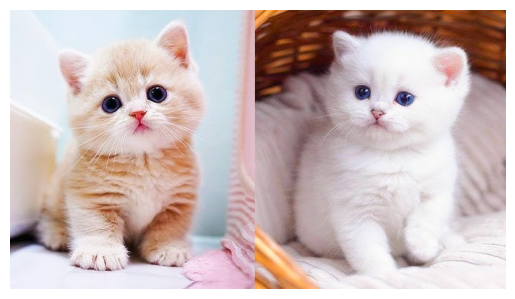

In [26]:
route = 'https://i.ytimg.com/vi/feEMKVcFyC4/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLCRnp5fFToaizxzl2wu9G78jacEjw'
im = loadImage(route,http=True)
show_image(im)

In [27]:
from io import BytesIO
import numpy as np

def imageToBytes(im):
    byte_io = BytesIO()
    np.save(byte_io, im)
    byte_data = byte_io.getvalue()
    return byte_data

def bytesToImage(byte_data):
    byte_io = BytesIO(byte_data)
    img_array = np.load(byte_io)
    return img_array

<class 'bytes'>


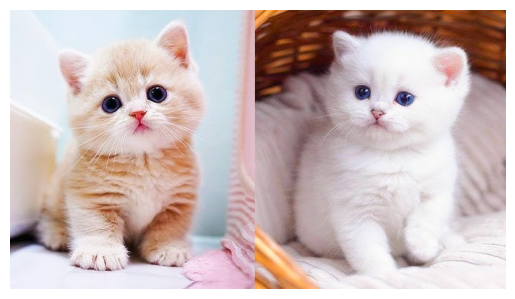

In [28]:
im_byte = imageToBytes(im)
print(type(im_byte))
im_r = bytesToImage(im_byte)
show_image(im_r)

Se diseñarán las funciones que dada la imagen como un arreglo de bytes, pueda codificarla o decodificarla en base 64

In [29]:
import base64

def imageEncodeBase64(bytes):
    return base64.b64encode(bytes)

def imageDecodeBase64(bytes):
    return base64.b64decode(bytes)

In [30]:
im_byte_b64 = imageEncodeBase64(im_byte)
im_byte_recovered = imageDecodeBase64(im_byte_b64)
assert im_byte_recovered==im_byte

Ahora hacemos el codigo que encripta y desencripta

In [41]:
import pyaes
import base64

base_key = b"CRYPTO IS FUN"
global_key_128 = base_key.ljust(16, b'\x00')
global_key_192 = base_key.ljust(24, b'\x00')
global_key_256 = base_key.ljust(32, b'\x00')

base_iv = b"IV_TEXT_12345678"
global_iv = base_iv.ljust(16, b'\x00')

def pad(data, block_size=16):
    padding_length = 16 - (len(data) % 16)
    padder = chr(padding_length).encode() * padding_length
    padded_message = data + padder
    return padded_message


def encrypt_bytes(byte_data, security_level=128):
    if security_level == 128:
        key = global_key_128
    elif security_level == 192:
        key = global_key_192
    elif security_level == 256:
        key = global_key_256
    else:
        raise ValueError("Invalid security level. Must be 128, 192, or 256 bits.")

    iv = global_iv
    padded_data = pad(byte_data)
    aes = pyaes.AESModeOfOperationCBC(key, iv)

    # Encrypt the image
    encrypted_image= b''

    # we divide the message into blocks of 16 bytes length
    for i in range(0, len(padded_data), 16):
        block = padded_data[i:i+16]
        aes = pyaes.AES(key)
        encrypted_block = aes.encrypt(block)
        encrypted_image += bytes(encrypted_block)

    encrypted_data = encrypted_image
    return encrypted_data , 16 - (len(byte_data) % 16)

def decrypt_bytes(encrypted_data, pad = 0, security_level=128):
    if security_level == 128:
        key = global_key_128
    elif security_level == 192:
        key = global_key_192
    elif security_level == 256:
        key = global_key_256
    else:
        raise ValueError("Invalid security level. Must be 128, 192, or 256 bits.")

    iv = global_iv
    aes = pyaes.AESModeOfOperationCBC(key, iv)

    decrypted_image = b''

    for i in range(0, len(encrypted_data), 16):
        block = encrypted_data[i:i+16]
        aes = pyaes.AES(key)
        decrypted_block = aes.decrypt(block)
        decrypted_image += bytes(decrypted_block)

    return decrypted_image[:-pad]

byte_data = b'This is some data to encrypt!'

encrypted_data , p = encrypt_bytes(byte_data, security_level=256)
print("Encrypted:", encrypted_data)

decrypted_data = decrypt_bytes(encrypted_data, pad=p, security_level=256)
print("Decrypted:", decrypted_data.decode('utf-8'))

Encrypted: b'#@"\xee\xefrQ\x18\xa2\xfe\xab&\x8d\xb4\xfe\x86\x018!hb}\xb0\xf4W\x9bv\x1f\xf2\x17UA'
Decrypted: This is some data to encrypt!


In [32]:
aes_im , p = encrypt_bytes(im_byte)
rec_im = decrypt_bytes(aes_im, pad = p)
assert im_byte == rec_im

Finalmente, vamos a encadenar el proceso que dada la ruta de una imagen, esta sea cargada, encriptada usando AES y codificada en base 64

In [33]:
def encodeImageB64(route,sec = 128,http=False):
    im = loadImage(route,http=http)
    print(f'Original Image')
    show_image(im)
    im_byte = imageToBytes(im)
    im_byte_des , pad = encrypt_bytes(im_byte, security_level=sec)
    im_byte_des_b64 = imageEncodeBase64(im_byte_des)
    return im_byte_des_b64.decode() , pad

In [34]:
def decodeImageB64(im_byte_des_b64_str,sec = 128,pad = 0):
    im_byte_des_b64 = im_byte_des_b64_str.encode()
    im_byte_des = imageDecodeBase64(im_byte_des_b64)
    im_byte = decrypt_bytes(im_byte_des , pad = pad, security_level=sec)
    im = bytesToImage(im_byte)
    print(f'Recovered Image')
    show_image(im)
    return im

Probamos las funciones

Original Image


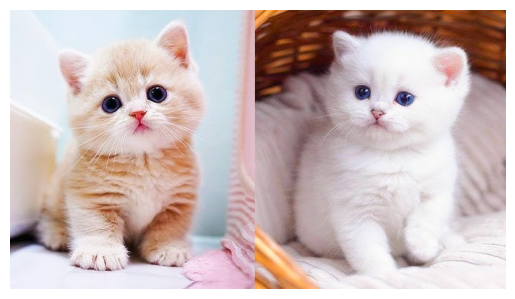

Text in base 64 length: 1059372
First 50 characters: nS2/Tp2In/VHMkVpo5U8cABHeu19eCQNeYggDkOGrO9xkdG+Yd


In [35]:
route = 'https://i.ytimg.com/vi/feEMKVcFyC4/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLCRnp5fFToaizxzl2wu9G78jacEjw'
textB64 , p = encodeImageB64(route,http=True,sec=192)
print(f'Text in base 64 length: {len(textB64)}\nFirst 50 characters: {textB64[:50]}')

Recovered Image


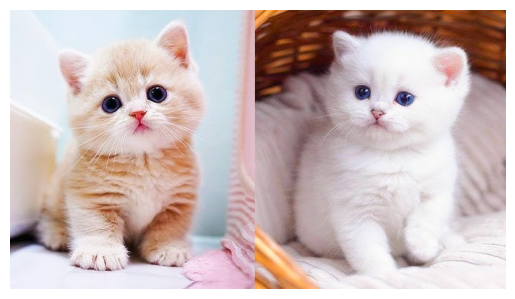

In [36]:
im = decodeImageB64(textB64, pad = p, sec = 192)

FInalmente unimos todo el proceso en una función principal

In [37]:
def AESMain():
    print('Bienvenido al programa de cifrado de imágenes con AES\n')
    mode = int(input('Elije el modo de operación (1 para cifrar, 2 para descifrar, 3 para salir): '))
    if mode==1:
        route = str(input('Ingresa la ruta de la imagen: '))
        http = True if int(input('Define si la imagen se debe recuperar usando http (1 para si): '))==1 else False
        sec = int(input('Ingrese el nivel de seguridad (128, 192, 256): '))
        print(sec)
        textB64,p = encodeImageB64(route,http=http,sec=sec)
        print(f'Padding involved: {p}')
        print(f'Text in base 64:\n{textB64}')
    elif mode==2:
        text = str(input('Ingresa el texto de la imagen cifrada: '))
        sec = int(input('Ingrese el nivel de seguridad (128, 192, 256): '))
        p = int(input('Ingresa el padding reportado: '))
        im = decodeImageB64(text,sec=sec, pad = p)
    else: return
    print()
    AESMain()

Bienvenido al programa de cifrado de imágenes con AES

Elije el modo de operación (1 para cifrar, 2 para descifrar, 3 para salir): 1
Ingresa la ruta de la imagen: https://images.stockcake.com/public/5/2/a/52aabfd8-a2cf-4644-a18d-085dcc3c6252_medium/intense-cat-gaze-stockcake.jpg
Define si la imagen se debe recuperar usando http (1 para si): 1
Ingrese el nivel de seguridad (128, 192, 256): 192
192
Original Image


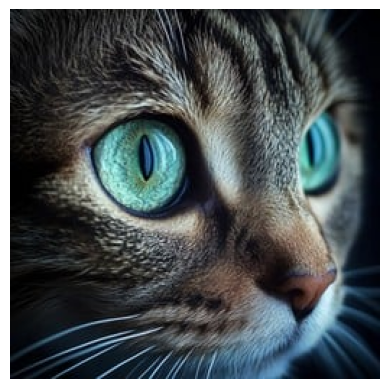

Padding involved: 16
Text in base 64:
nS2/Tp2In/VHMkVpo5U8cABHeu19eCQNeYggDkOGrO9xkdG+Ydht4YGT8JkLOIS38VEfjUA267dO2hI4ozhNSk2VdNv4OM0fx2fqGSgeTb0pwlJ4gpKXaz6fiK7QxDd8KcJSeIKSl2s+n4iu0MQ3fBaQGeAMJzM3sOd0GjJuw+71eXZ2DXfBaYNlvjof0ktbijvFlmFZFNKipl1P/zqAEw+LukzgtGxcZLKO5/7I9AkfRfHS7O+zowy43fQKcPDIMJ2U5qIHs+tM2ybRbvnkanHypa0Om2SyvqGiiqghr83ub2yTztd0wbzvMvKDbFi6sWyb5NiTj3THJnR5uaDVOXPHp62ftQ7ieMOgnbNfFhyi7C8lgcBRB5Jd75qxsoJqxvfS8Hcyb2Vhy+MdJ9pkzH7wjZVuhXaswvW2HNTBl5IGkmOifGblIWAQIf3W+ReQsQaiHSjCdch21OE624sJKFpYVzEB0NHotYyH58LqffO1jqX8o01i4laaIxCNwTm5ob1azqosB1imBTZMxTP091gXjxBhIwTyj1xb5pN3K9idpJlGxT0XfcUZba7Qhg3nRamcduP3Rz0cx2J3j/iV51byfRKbBbnjc6905gTFnW53xWdj8vO503PG0piY11R3t91I+QnCJ337nfjZ2wYfx68dZr+nNpMSNrxRP5Dm9lT+W7GHrX5r8OzXZgouBQINtBHUnl2Rul2QdMHoHqUJKxTXnIwWDz4hUeG6Zz7cZH5oZ7DWqW0zZObH4w/OxK2qk2YnzsANzr1i4XLg1ntBtTHBRjQOA/8ndJ/kgNaGQP+7w8GFFQzCIg7jpW9+l1VqGhtw1XoCXVuRo+PML/3HKbdAgRqymZKkjdak5BzWsxNI070dfP4kcuVSHamUxYJjx59tEnwVxkgik4f1HkmN/Oz/mu8qdBB0Ki4tRKOYO3dUDvX/2NzZeec3TZAq2EqeQD

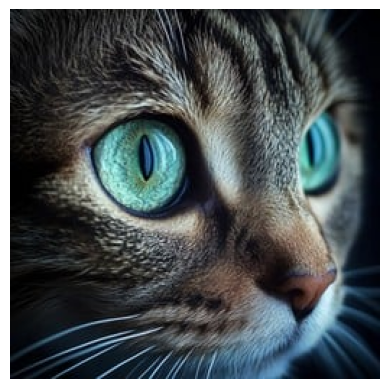


Bienvenido al programa de cifrado de imágenes con AES

Elije el modo de operación (1 para cifrar, 2 para descifrar, 3 para salir): 3


In [43]:
AESMain()